Import statements from Matt

In [68]:
import astropy
from astropy.io import fits
import numpy as np 
import textwrap
import matplotlib.pyplot as plt
import os, sys 
import importlib
import glob
from tqdm import tqdm


from astropy.time import Time
from astropy.units import allclose as quantity_allclose
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.coordinates.builtin_frames import FK5, ICRS, GCRS, GeocentricMeanEcliptic, BarycentricMeanEcliptic, HeliocentricMeanEcliptic, GeocentricTrueEcliptic, BarycentricTrueEcliptic, HeliocentricTrueEcliptic, HeliocentricEclipticIAU76
from astropy.constants import R_sun, R_earth
from astropy.wcs import WCS

import fitsio


# -------------------------------------------------------------------------------------
# Local imports
# -------------------------------------------------------------------------------------
sys.path.append(os.path.join(os.path.split(os.getcwd())[0], 'shifty'))
import known
import downloader

importlib.reload(known)
importlib.reload(downloader)


<module 'downloader' from '/arc/home/mikea/Github/shifty/shifty/downloader.py'>

In [69]:
import astropy 
astropy.__version__ , astropy.__path__

('5.1', ['/opt/conda/lib/python3.9/site-packages/astropy'])

In [70]:
# Some notes on which camera/ccd/etc we expect Sedna to be in 
# - These came from inputing 57.136 7.6549 into lightkurve's tess-cut/tess-search function 
camera = 1 
ccd = 4
col, row = 1550, 1101

In [71]:
importlib.reload(known)
K = known.Known()

# These are the values from JPL at hourly intervals
JD_, RA_, Dec_  = K._radec_for_sedna()
for t,r,d in zip(JD_[:2], RA_[:2], Dec_[:2]):
    print(t,r,d)
print()

# Plot the positions across the course of the November 2019 (Sector-5) period  
RA_, Dec_ = K._interpolate_radec_for_sedna(JD_)
#plt.plot(JD_, RA_ , '.')
#plt.plot(JD_, Dec_ , '.')

2458436.5 57.136303009 7.65500855
2458436.541666667 57.135914678 7.65489896



In [72]:
# Local imports
sys.path.append(os.path.join(os.path.split(os.getcwd())[0], 'shifty'))
import imagehandler
importlib.reload(imagehandler)
import glob
filenames=sorted(glob.glob('/arc/home/mikea/.shifty_data/tess/5/1/4/tess20183??????*.fits'))[0::1]
print(f"{len(filenames)} files")
#print(' '.join(filenames))

1108 files


In [73]:
import importlib
importlib.reload(imagehandler)
D=imagehandler.DataHandler(filenames, extno=1, EXPTIME='EXPOSURE', EXPUNIT='d', MAGZERO=18.,
                           MJD_START='BJDREFI+TSTART+-2400000.5', GAIN='GAINA', FILTER='-Tess', verbose=False
                           , xycuts=[1000, 1250, 1400, 1700])

Reading image 1107: /arc/home/mikea/.shifty_data/tess/5/1/4/tess2018345002937-s0005-1-4-0125-s_ffic.fits
Read 1108 files!


In [74]:
times=[]
raw_flux=[]
times_tess=[]
for i, d in enumerate(D.image_data.header):
    raw_flux.append(np.nanmedian(D.image_data.data[i]))
    times.append(d['SHIFTY_MJD_MID'])
    times_tess.append(d['TSTART'])
    if d['DQUALITY']!=0:
        print(i, d['DQUALITY'])

In [75]:
plt.plot(times, raw_flux, '.')

let's get predicted RA and Dec for Sedna at each cadence

In [76]:
from tqdm import tnrange

And then we'll use WCS tools to convert these coordinates at each cadence to a pixel position at each cadence.

In [77]:
shifts = D._calculate_shifts_from_known(object_name='Sedna', obs_code='500@-95')

In [78]:
y, x = -shifts.T

In [79]:
plt.plot(x,y, '.')

In [80]:
from astropy.io import fits

And then let's use it. At each cadence, draw a 27x27 region from the postcard centered on the expected position of Sedna. We'll subtract off the median of the 100 cadences on either side of the postcard frame to use as a median model of what the stars are doing. Then stack up these shifted frames. For coding convenience/laziness I'm only selecting the region when this entire TPF would fall onto the postcard, and excluding the first and last 100 frames for median calculations, but there's no reason we couldn't do both of those more properly.

We could also pre-compute the median frames and do that calculation much more quickly than I'm doing it here.

It would also be good to split up the two orbits, right now the last 100 frames of the first orbit include median information from the first 100 cadences of the second orbit, where we know the pointing is different.

In [82]:
size = len(D.image_data.data)
runmed = np.zeros(D.image_data.data.shape)
output = np.full((size, 153, 153), np.nan)

for i in tnrange(100, size-100):

    a1 = int(np.round((x[i]), 0))  # What is the +148/2 about?
    a2 = int(np.round((y[i]), 0))   # What is the +104/2 about?
    #print(a1, a2)
    
    if ((a1 > 77) and (a2 > 77)):  
        #print(i)
        runmed[i] = np.nanmedian(D.image_data.data[i-100:i+100], axis=(0))
        medsub = D.image_data.data[i] - runmed[i]

        #plt.clf()
        #plt.imshow(medsub, vmin=-1, vmax=1, origin='lower')
        #plt.plot(a1,a2, 'rx', alpha=0.9, markersize=16)
        #print(a1, a2)
        #plt.savefig('frames/%04i.png'%i)
        output[i] = medsub[a2-76:a2+77, a1-76:a1+77]
        #output[i] = medsub
        #output[i] = a[2].data[q][i,a2-26:a2+27, a1-26:a1+27] 
        #bkgput[i] = bkg_[1].data[q][i,a1-26:a1+27, a2-26:a2+27]

/tmp/ipykernel_65/2320801388.py:5: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(100, size-100):


  0%|          | 0/908 [00:00<?, ?it/s]

In [83]:
print(' data shape ', D.image_data.data.shape)
print(' output shape ', output.shape)
print(' runmed shape ', runmed.shape)
print( ' output-sum ' ,np.sum(output))
print( ' runmed-sum ' ,np.sum(runmed))


 data shape  (1108, 250, 300)
 output shape  (1108, 153, 153)
 runmed shape  (1108, 250, 300)
 output-sum  nan
 runmed-sum  13553134392.376923


Do we see Sedna?

flux1 shape  (272, 153, 153)
  flux1 min, max  -297.47021484375 227.923828125
   flux1 sum  2327292.652404785
outvar1    shape  (153, 153)
outvar1 min, max  -0.41100311279296875 1.554718017578125
 outvar1 sum  1086.7116088867188


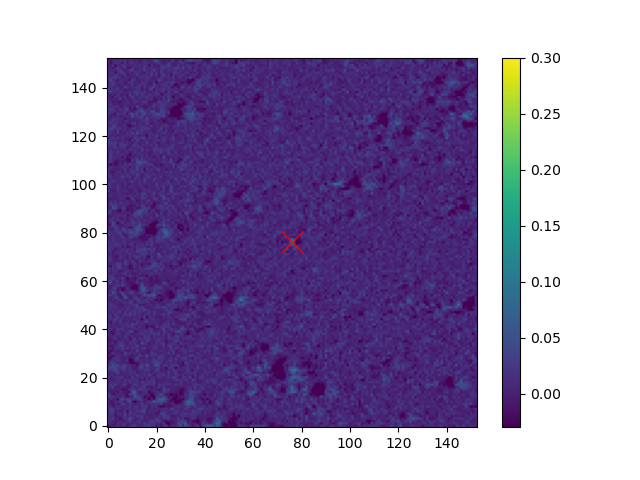

In [119]:
%matplotlib widget
flux0 = output[0:275] #- bkgput[150:500] +0.0 #+ bkgput[50:500]
outvar0 = np.nanmedian(flux0, axis=(0))

flux1 = output[275:547] #- bkgput[150:500] +0.0 #+ bkgput[50:500]
outvar1 = np.nanmedian(flux1, axis=(0))

flux2 = output[547:825] #- bkgput[800:1100] +0.0 #+ bkgput[700:1100]
outvar2 = np.nanmedian(flux2, axis=(0))

flux3 = output[825:1100] #- bkgput[800:1100] +0.0 #+ bkgput[700:1100]
outvar3 = np.nanmedian(flux3, axis=(0))

#outvar = outvar1 + outvar2

outvar = np.nanmedian(output, axis=(0))


plt.imshow(outvar, vmin=-0.03, vmax=0.3, origin='lower')

plt.plot(76,76, 'rx', alpha=0.9, markersize=16)

plt.colorbar()

print('flux1 shape ',      flux1.shape)
print('  flux1 min, max ', np.min(flux1) , np.max(flux1))
print('   flux1 sum ',      np.sum(flux1) )
print('outvar1    shape ', outvar1.shape)
print('outvar1 min, max ', np.min(outvar1) , np.max(outvar1))
print(' outvar1 sum ',      np.sum(outvar1) )


Oh shit we do! And it's not a systematic like a cosmic ray, if we chunk the first and second half of the data we see it in each.

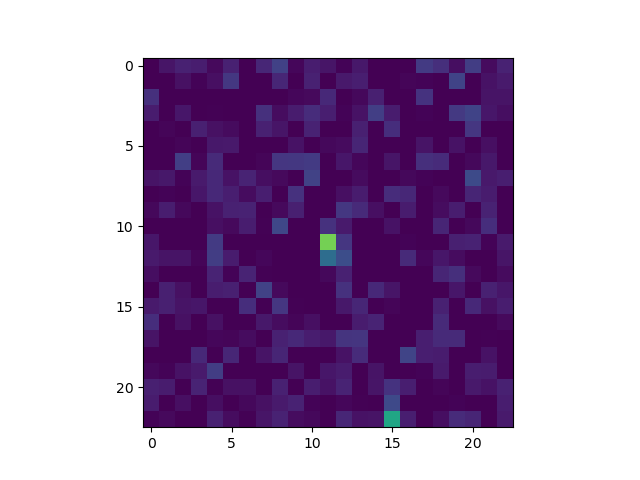

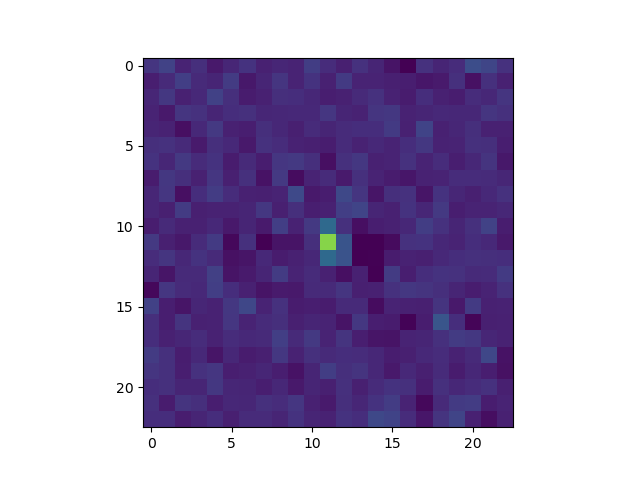

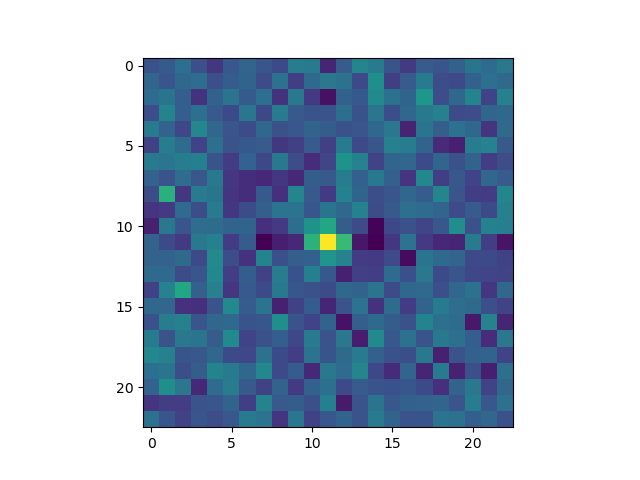

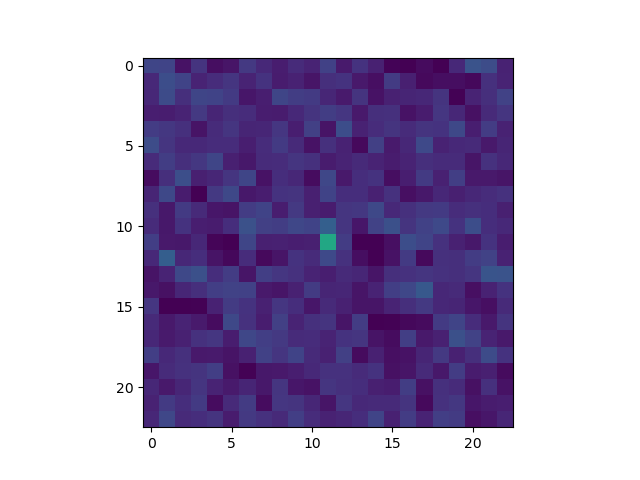

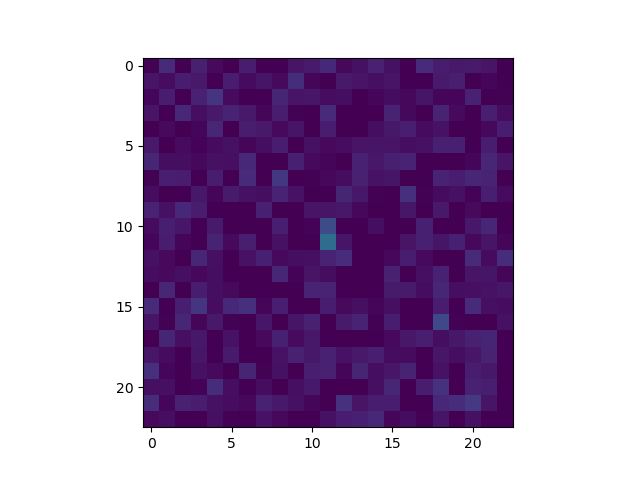

In [120]:
plt.figure()
plt.imshow(outvar[65:88,65:88], vmin=-0.03, vmax=0.3)
plt.figure()
plt.imshow(outvar0[65:88,65:88], vmin=-0.03, vmax=0.3)
plt.figure()
plt.imshow(outvar1[65:88,65:88], vmin=-0.03, vmax=0.6)
plt.figure()
plt.imshow(outvar2[65:88,65:88], vmin=-0.03, vmax=0.3)
plt.figure()
plt.imshow(outvar3[65:88,65:88], vmin=-0.03, vmax=0.3)
plt.show()

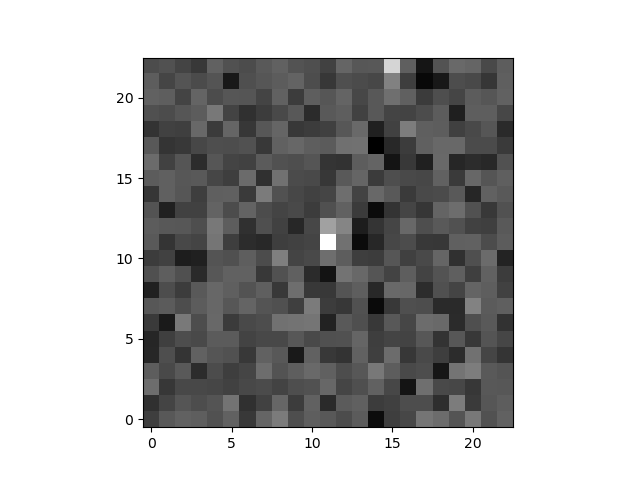

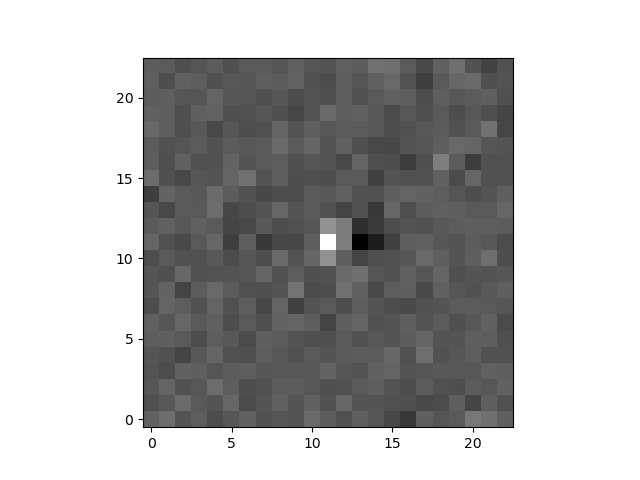

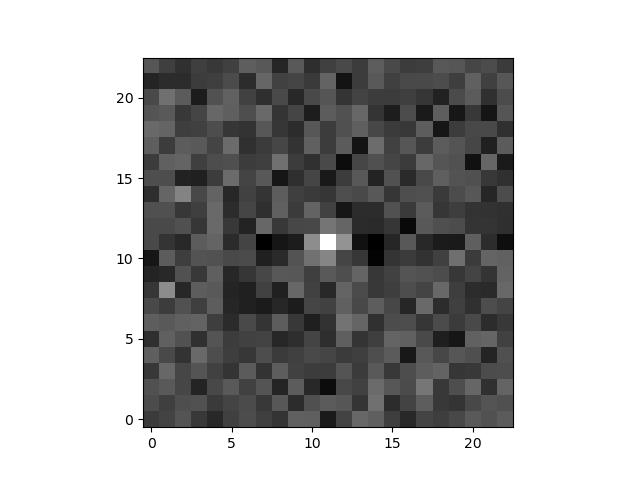

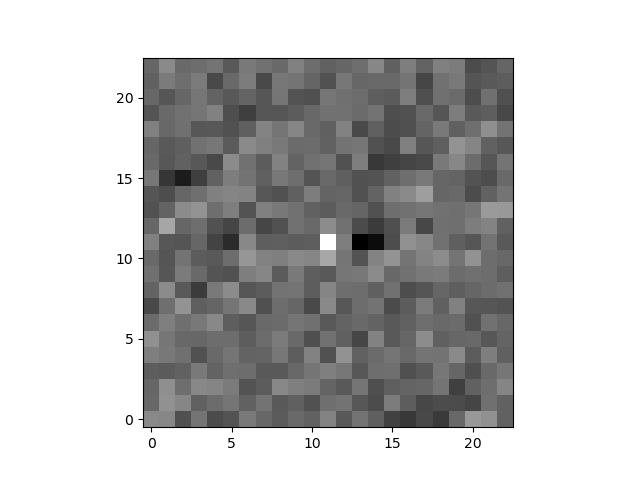

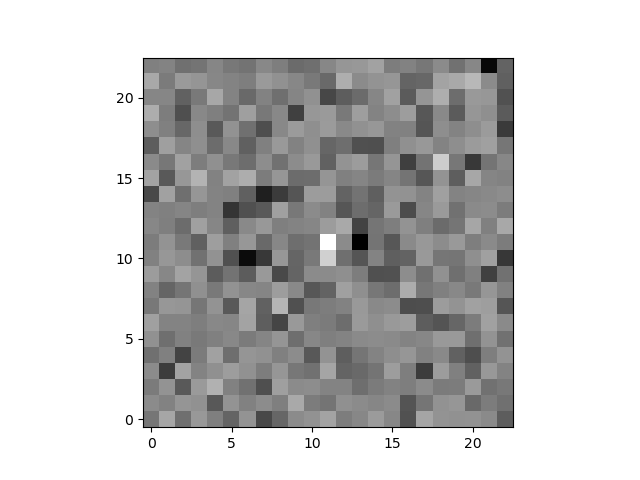

In [121]:
from matplotlib.colors import LogNorm
plt.figure()
plt.imshow(outvar[65:88,65:88]+1, origin='lower', cmap='gray',norm=LogNorm())
plt.figure()
plt.imshow(outvar0[65:88,65:88]+1, origin='lower', cmap='gray',norm=LogNorm())
plt.figure()
plt.imshow(outvar1[65:88,65:88]+1, origin='lower', cmap='gray',norm=LogNorm())
plt.figure()
plt.imshow(outvar2[65:88,65:88]+1, origin='lower', cmap='gray',norm=LogNorm())
plt.figure()
plt.imshow(outvar3[65:88,65:88]+1, origin='lower', cmap='gray',norm=LogNorm())
plt.show()

In [122]:
counts_above_background = (outvar-np.median(outvar3))
peak_count = np.max(counts_above_background[20:-20,20:-20])
noise = np.std(counts_above_background[10:-10,10:-10])
sigma = peak_count / noise
#display(Markdown(fr'Peak count $\pm$ noise = {peak_count:4.1f} $\pm$ {noise:4.1f} ({sigma:4.1f}$\sigma$)'))
print(fr'Peak count $\pm$ noise = {peak_count:4.1f} $\pm$ {noise:4.1f} ({sigma:4.1f}$\sigma$)')

Peak count $\pm$ noise =  0.3 $\pm$  0.0 (16.2$\sigma$)


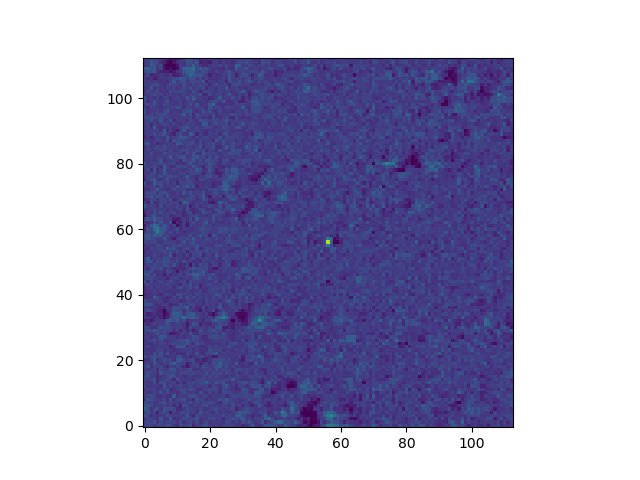

In [123]:
plt.imshow(counts_above_background[20:-20,20:-20], vmin=-0.03, vmax=0.3, origin='lower')
plt.show()

In [51]:
i=5
j=4
print(f'f_{i:0{j}.0f}.fits')

f_0005.fits
